<a href="https://colab.research.google.com/github/tsuji-mutsushi/ai_robotics_lab_2025_nodlecompetition/blob/main/week06_image_classification_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Competition

## About Competition




### Kaggle


*   The competition is held on the Kaggle platform.
*   Please join the competition from the invitation link shared on our Teams channel.



### Timeline
*   2025/10/15 --- Start Competition
*   2025/11/04 23:00 (Taiwan), 24:00 (Japan) --- Submission Deadline
*   2025/11/05 1:00 (Taiwan), 2:00(Japan) --- Final Leaderboard Release

### Rules

* One account per participant
    * You should use only one Kaggle account for the competition. You cannot submit your solution from your multiple accounts.

* DL Models
    * You can use any deep learning models for the competition. **However, you cannot use pretrained weights.** You can still use popular models such as VGG and ResNet etc., but you need to train them from scratch.

* Datasets
    * You can only use the data in `dataset2025` for training your model. You cannot use the data other than `dataset2025`.

* Computational Resources
    * If you have access to GPU machines other than Google Colab, you can use them.

* Submission Limits
    * You can submit up to 10 prediction files per day. However, you need to select only one prediction file for the final score evaluation.

* Leaderboard
    * Before the submission deadline, the leaderboard shows the accuracies evaluated for 20% of the test dataset. The final results will be based on the other 80% of the test dataset.




### GPU

Please make sure your runtime type is set to GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown

### Download Data

Unlike the CIFAR10 dataset, the data we will be using here consists of regular JPEG files. Therefore, we need to prepare the dataset for PyTorch to process.

The noodle image data can be downloaded using the code below. Once the download is complete, you will find `dataset2025.zip` in the Files tab on the left side.

In [3]:
! gdown "https://drive.google.com/uc?export=download&id=1uqLA7SoJRDmuABbPf_GwPDKakgMwNfnu"

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1uqLA7SoJRDmuABbPf_GwPDKakgMwNfnu
From (redirected): https://drive.google.com/uc?export=download&id=1uqLA7SoJRDmuABbPf_GwPDKakgMwNfnu&confirm=t&uuid=65d39eb6-b116-4415-8c56-d66c28e4a8b3
To: /content/dataset2025.zip
100% 335M/335M [00:05<00:00, 56.9MB/s]


In [4]:
! unzip dataset2025.zip  > /dev/null 2>&1

In [5]:
for subdir in ["train", "test"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join("dataset2025", subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join("dataset2025", subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))
        for filename in filenames[:5]:
            print("    ---", filename)

train
--- 0_spaghetti : 1725
    --- spaghetti_2542.jpg
    --- spaghetti_1177.jpg
    --- spaghetti_0335.jpg
    --- spaghetti_0828.jpg
    --- spaghetti_0466.jpg
--- 1_ramen : 1799
    --- ramen_1529.jpg
    --- ramen_0646.jpg
    --- ramen_1456.jpg
    --- ramen_1047.jpg
    --- ramen_0685.jpg
--- 2_udon : 1756
    --- udon_1474.jpg
    --- udon_1847.jpg
    --- udon_0553.jpg
    --- udon_0114.jpg
    --- udon_1761.jpg
test
--- unknown : 4179
    --- test_4139.jpg
    --- test_3045.jpg
    --- test_3248.jpg
    --- test_2924.jpg
    --- test_0757.jpg


### Create Dataset
To create PyTorch datasets with this tree-structured directory format, we can use `torchvision.datasets.ImageFolder` class.

In [6]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="dataset2025/train")
test_dataset = ImageFolder(root="dataset2025/test")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

train_dataset: 5280
test_dataset: 4179


In [7]:
train_dataset.class_to_idx

{'0_spaghetti': 0, '1_ramen': 1, '2_udon': 2}

In [8]:
classnames = {0:"spaghetti", 1:"ramen", 2:"udon"}
classnames

{0: 'spaghetti', 1: 'ramen', 2: 'udon'}

In [9]:
test_dataset.class_to_idx

{'unknown': 0}

# 正規化

In [10]:
# --- 学習データの mean/std を算出する専用セル ---
# 既存構造を崩さないため、"train_dataset = ImageFolder(root=...)" で定義した直後に置く
# 計算は「v2.Resize((96,96)) → v2.ToTensor()」後のテンソルに対して行う

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch
import math

# 既存の画像サイズと一致させる（ノート内のtransformは 96x96 なのでそれに合わせる）
_tmp_tf = v2.Compose([
    v2.Resize((96, 96)),
    v2.ToTensor()
])

# 正規化なしのテンソルで mean/std を出すため、一時的に別Datasetを作成（既存の変数名・流れは変更しない）
_tmp_train = ImageFolder(root="dataset2025/train", transform=_tmp_tf)

# DataLoaderで全画像を走査してチャンネルごとの平均・分散を集計（バッチ単位で安全に）
_tmp_loader = DataLoader(_tmp_train, batch_size=160, shuffle=False, num_workers=2)

# 集計用
n_pixels = 0
sum_c = torch.zeros(3)
sumsq_c = torch.zeros(3)

for x, _ in _tmp_loader:
    # x: [B, C, H, W] （ToTensor後は [0,1] のfloat）
    b, c, h, w = x.shape
    num = b * h * w
    n_pixels += num
    # バッチ内の各チャンネルの和・二乗和を加算
    sum_c += x.sum(dim=(0, 2, 3))
    sumsq_c += (x ** 2).sum(dim=(0, 2, 3))

# 平均と標準偏差（母集団の式：std = sqrt(E[x^2] - (E[x])^2)）
TRAIN_MEAN = (sum_c / n_pixels).tolist()
TRAIN_STD = torch.sqrt(sumsq_c / n_pixels - (sum_c / n_pixels) ** 2).tolist()

print(f"[INFO] TRAIN_MEAN = {TRAIN_MEAN}")
print(f"[INFO] TRAIN_STD  = {TRAIN_STD}")

# 以降のセル（transform定義セル）で v2.Normalize(TRAIN_MEAN, TRAIN_STD) を使います


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


[INFO] TRAIN_MEAN = [0.623147189617157, 0.531842052936554, 0.4104785621166229]
[INFO] TRAIN_STD  = [0.27282580733299255, 0.27242353558540344, 0.2887946367263794]


## Data Augumentation

In [11]:
# # --- データ拡張 強度パラメータ（数値を変えるだけで強度調整できます） ---

# # 幾何変換（回転/並進/スケール/シア）
# AUG_ROT_DEG   = 10                 # 回転角度（±）
# AUG_TRANSLATE = (0.05, 0.05)       # 並進（幅・高さに対する比率）
# AUG_SCALE     = (0.95, 1.05)       # スケール範囲（最小, 最大）
# AUG_SHEAR     = 5                  # シア角度（±）

# # 左右反転
# AUG_HFLIP_P   = 0.5                # 左右反転の確率

# # 色変換（ColorJitter）
# AUG_JIT_B     = 0.20               # 明るさ
# AUG_JIT_C     = 0.20               # コントラスト
# AUG_JIT_S     = 0.20               # 彩度
# AUG_JIT_H     = 0.10               # 色相

# # RandomErasing（学習時のみ、正規化後に適用）
# AUG_ERASE_P       = 0.25           # 適用確率（0なら無効）
# AUG_ERASE_SCALE   = (0.02, 0.12)   # 消去領域の面積比（最小, 最大）
# AUG_ERASE_RATIO   = (0.3, 3.3)     # 縦横比の範囲

# =======================
# ▼ 数値例（そのままコピペで強度変更できます）
# 【弱め（小さな揺らぎ）】
# AUG_ROT_DEG=5;  AUG_TRANSLATE=(0.02,0.02); AUG_SCALE=(0.98,1.02); AUG_SHEAR=2
# AUG_HFLIP_P=0.3
# AUG_JIT_B=0.10; AUG_JIT_C=0.10; AUG_JIT_S=0.10; AUG_JIT_H=0.05
# AUG_ERASE_P=0.10; AUG_ERASE_SCALE=(0.01,0.06); AUG_ERASE_RATIO=(0.4,2.5)
#
#【中くらい（バランス重視）← 初期値】
# AUG_ROT_DEG=10; AUG_TRANSLATE=(0.05,0.05); AUG_SCALE=(0.95,1.05); AUG_SHEAR=5
# AUG_HFLIP_P=0.5
# AUG_JIT_B=0.20; AUG_JIT_C=0.20; AUG_JIT_S=0.20; AUG_JIT_H=0.10
# AUG_ERASE_P=0.25; AUG_ERASE_SCALE=(0.02,0.12); AUG_ERASE_RATIO=(0.3,3.3)
#
#【強め（過学習気味のとき）】
AUG_ROT_DEG=15; AUG_TRANSLATE=(0.08,0.08); AUG_SCALE=(0.90,1.10); AUG_SHEAR=8
AUG_HFLIP_P=0.6
AUG_JIT_B=0.30; AUG_JIT_C=0.30; AUG_JIT_S=0.30; AUG_JIT_H=0.15
AUG_ERASE_P=0.35; AUG_ERASE_SCALE=(0.02,0.18); AUG_ERASE_RATIO=(0.25,3.5)

# ※ 無効化したい場合の目安：
#   - 反転を止める：AUG_HFLIP_P = 0.0
#   - 幾何変換を止める：AUG_ROT_DEG=0; AUG_TRANSLATE=(0.0,0.0); AUG_SCALE=(1.0,1.0); AUG_SHEAR=0
#   - 色揺らぎを止める：AUG_JIT_* をすべて 0.0
#   - Erasingを止める：AUG_ERASE_P = 0.0


In [12]:
from torchvision.transforms import v2

train_dataset = ImageFolder(root="dataset2025/train",
                            transform=v2.Compose([
                                # --- 幾何系の拡張（順番は一般的な推奨例） ---
                                v2.RandomHorizontalFlip(p=AUG_HFLIP_P),
                                v2.RandomAffine(
                                    degrees=AUG_ROT_DEG,
                                    translate=AUG_TRANSLATE,
                                    scale=AUG_SCALE,
                                    shear=AUG_SHEAR
                                ),
                                # --- 色系の拡張 ---
                                v2.ColorJitter(
                                    brightness=AUG_JIT_B,
                                    contrast=AUG_JIT_C,
                                    saturation=AUG_JIT_S,
                                    hue=AUG_JIT_H
                                ),
                                # --- 既存のサイズ変換・テンソル化 ---
                                v2.Resize((96, 96)),
                                v2.ToTensor(),
                                # --- 正規化（自前データのmean/stdを使用） ---
                                v2.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
                                # --- RandomErasing（テンソル化・正規化後が推奨） ---
                                v2.RandomErasing(
                                    p=AUG_ERASE_P,
                                    scale=AUG_ERASE_SCALE,
                                    ratio=AUG_ERASE_RATIO,
                                    value='random'  # 正規化済みでもOK（内部で自動処理）
                                ),
                            ])
)

test_dataset = ImageFolder(root="dataset2025/test",
                           transform=v2.Compose([
                                v2.Resize((96, 96)),
                                v2.ToTensor(),
                                v2.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD)  # ★ 学習データ由来の統計で正規化
                           ])
)


In [13]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.9)    # 50% will be training data
valid_size = n_samples - train_size  # 50% will be validation data

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

train data 4752
validation data 528


### DataLoader

Then we create the dataloaders for the training, validation and test dataset.

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=352, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=352, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=352, shuffle=False, num_workers=2)

## Model Building

### SimpleCNN

In [15]:
import torch
import torch.nn as nn

# 軽量CNNモデル（96x96画像用に最適化）
class CompactCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CompactCNN, self).__init__()

        # 特徴抽出部
        self.features = nn.Sequential(
            # Block 1: 96x96 -> 48x48
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),

            # Block 2: 48x48 -> 24x24
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),

            # Block 3: 24x24 -> 12x12
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # 分類部
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

model = CompactCNN(num_classes=3).to(device)

## Training

In [16]:
!pip install schedulefree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00


In [17]:
from schedulefree import RAdamScheduleFree

### Training Loop







In [18]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# AMPの設定
use_amp = True  # AMPを使用するかどうか
scaler = GradScaler() if use_amp else None

loss_func = nn.CrossEntropyLoss()
optimizer = RAdamScheduleFree(model.parameters(), lr=0.1, weight_decay=4e-4)
epochs = 60

# メトリクス保存用リスト
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

# Google Driveへのチェックポイント保存パス（必要に応じて変更）
checkpoint_path = "/content/drive/MyDrive/model_checkpoints"
from google.colab import drive
drive.mount('/content/drive')

/tmp/ipython-input-2336995850.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


In [28]:
# === 最新チェックポイントを探してロード → 続きから学習できるようにセットアップ ===
import os, re, glob, torch

# 追加で学習したいエポック数（例：さらに10epoch）
additional_epochs = 30

# --- 最新ファイルを自動検出（checkpoint_epoch_XX.pth の最大XXを選ぶ） ---
ckpt_files = glob.glob(os.path.join(checkpoint_path, "checkpoint_epoch_*.pth"))
if len(ckpt_files) == 0:
    raise FileNotFoundError("チェックポイントが見つかりません。まずは通常学習を一度完了させてください。")

def _extract_epoch(fname: str) -> int:
    m = re.search(r"checkpoint_epoch_(\d+)\.pth", os.path.basename(fname))
    return int(m.group(1)) if m else -1

ckpt_files_sorted = sorted(ckpt_files, key=_extract_epoch)
latest_ckpt = ckpt_files_sorted[-1]
last_epoch_num = _extract_epoch(latest_ckpt)

print(f"[INFO] 最新チェックポイント: {latest_ckpt} (epoch={last_epoch_num})")

# --- ロード（map_location=device でGPU/CPUに合わせる） ---
ckpt = torch.load(latest_ckpt, map_location=device)

# ★ モデルの状態を復元
model.load_state_dict(ckpt["model_state_dict"])

# ★ Optimizerの状態を復元
optimizer.load_state_dict(ckpt["optimizer_state_dict"])

# ★ AMP使用時はGradScalerも復元（保存がNoneの場合はスキップ）
if use_amp and (ckpt.get("scaler_state_dict", None) is not None):
    scaler.load_state_dict(ckpt["scaler_state_dict"])
elif use_amp:
    # 旧チェックポイント等でscalerが無い場合は初期化済みscalerをそのまま使う
    pass

# --- 再開エポックと総エポック数を上書き ---
# 既存ループの for epoch in range(epochs) を活かすため、
# これから回す「総エポック数」を last_epoch 以降に伸ばす。
start_epoch = last_epoch_num            # 0始まり前提の保存だったため、この後のループは start から開始
epochs = last_epoch_num + additional_epochs  # 既存変数 epochs を上書きして「合計の到達目標」にする

print(f"[RESUME] start_epoch={start_epoch}, これから {additional_epochs} epoch 追加学習 → 目標 epoch={epochs}")
model.to(device)  # 念のため

[INFO] 最新チェックポイント: /content/drive/MyDrive/model_checkpoints/checkpoint_epoch_60.pth (epoch=60)
[RESUME] start_epoch=60, これから 30 epoch 追加学習 → 目標 epoch=90


CompactCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
for epoch in range(start_epoch, epochs):  # ★ 再開点から最終目標まで回す
    print(f"Epoch {epoch+1}/{epochs}")

    # メトリクス初期化
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()
    optimizer.train()

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        # AMPを使用した順伝播と損失計算
        if use_amp:
            with autocast():
                p_batch = model(x_batch)
                loss = loss_func(p_batch, y_batch)

            # スケールされた勾配計算とパラメータ更新
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            p_batch = model(x_batch)
            loss = loss_func(p_batch, y_batch)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        p_batch_label = torch.argmax(p_batch, dim=1)
        train_correct_count += (p_batch_label == y_batch).sum()

        pbar.set_postfix({
            "accuracy": f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}",
            "loss": f"{loss.item():.4f}"
        })

    #--- Evaluation Phase ---#
    with torch.no_grad():
        model.eval()
        optimizer.eval()

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid")

        for x_batch, y_batch in pbar:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # 評価時もAMPを使用（推論高速化）
            if use_amp:
                with autocast():
                    p_batch = model(x_batch)
                    loss = loss_func(p_batch, y_batch)
            else:
                p_batch = model(x_batch)
                loss = loss_func(p_batch, y_batch)

            valid_loss += loss.item()
            p_batch_label = torch.argmax(p_batch, dim=1)
            valid_correct_count += (p_batch_label == y_batch).sum()

            pbar.set_postfix({
                "accuracy": f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}",
                "loss": f"{loss.item():.4f}"
            })

    # メトリクス計算
    train_accuracy = train_correct_count.item() / len(train_dataset)
    valid_accuracy = valid_correct_count.item() / len(valid_dataset)
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    # 結果表示と保存
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, "
          f"Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")

    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)

    # Google Driveにチェックポイント保存（10エポックごと）
    if (epoch + 1) % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict() if use_amp else None,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
        }, f"{checkpoint_path}/checkpoint_epoch_{epoch+1}.pth")
        print(f"チェックポイント保存: epoch {epoch+1}")

    print("---------------------")
print("学習完了！")

Epoch 61/90


Train:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipython-input-3564095117.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Valid:   0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipython-input-3564095117.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Valid: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, accuracy=0.8523, loss=0.3254]


Train: Accuracy=0.801 Loss=0.487, Valid: Accuracy=0.860 Loss=0.360
---------------------
Epoch 62/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it, accuracy=0.8977, loss=0.3036]


Train: Accuracy=0.812 Loss=0.481, Valid: Accuracy=0.871 Loss=0.339
---------------------
Epoch 63/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, accuracy=0.8864, loss=0.2801]


Train: Accuracy=0.818 Loss=0.459, Valid: Accuracy=0.867 Loss=0.332
---------------------
Epoch 64/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, accuracy=0.8693, loss=0.3232]


Train: Accuracy=0.818 Loss=0.464, Valid: Accuracy=0.841 Loss=0.373
---------------------
Epoch 65/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it, accuracy=0.8977, loss=0.2816]


Train: Accuracy=0.816 Loss=0.467, Valid: Accuracy=0.883 Loss=0.331
---------------------
Epoch 66/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, accuracy=0.8807, loss=0.3217]


Train: Accuracy=0.824 Loss=0.454, Valid: Accuracy=0.862 Loss=0.349
---------------------
Epoch 67/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, accuracy=0.8750, loss=0.3288]


Train: Accuracy=0.818 Loss=0.462, Valid: Accuracy=0.848 Loss=0.362
---------------------
Epoch 68/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it, accuracy=0.8864, loss=0.3062]


Train: Accuracy=0.824 Loss=0.445, Valid: Accuracy=0.850 Loss=0.362
---------------------
Epoch 69/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it, accuracy=0.8750, loss=0.3097]


Train: Accuracy=0.820 Loss=0.446, Valid: Accuracy=0.854 Loss=0.342
---------------------
Epoch 70/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it, accuracy=0.8864, loss=0.2966]


Train: Accuracy=0.832 Loss=0.434, Valid: Accuracy=0.850 Loss=0.331
---------------------
Epoch 71/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.75s/it, accuracy=0.8295, loss=0.3340]


Train: Accuracy=0.830 Loss=0.445, Valid: Accuracy=0.835 Loss=0.367
---------------------
Epoch 72/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it, accuracy=0.8750, loss=0.2982]


Train: Accuracy=0.831 Loss=0.444, Valid: Accuracy=0.854 Loss=0.354
---------------------
Epoch 73/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it, accuracy=0.9091, loss=0.2877]


Train: Accuracy=0.834 Loss=0.419, Valid: Accuracy=0.877 Loss=0.336
---------------------
Epoch 74/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.83s/it, accuracy=0.8920, loss=0.2868]


Train: Accuracy=0.827 Loss=0.462, Valid: Accuracy=0.862 Loss=0.341
---------------------
Epoch 75/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it, accuracy=0.8693, loss=0.3015]


Train: Accuracy=0.822 Loss=0.438, Valid: Accuracy=0.867 Loss=0.335
---------------------
Epoch 76/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it, accuracy=0.8693, loss=0.2860]


Train: Accuracy=0.846 Loss=0.415, Valid: Accuracy=0.871 Loss=0.324
---------------------
Epoch 77/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.83s/it, accuracy=0.8864, loss=0.2779]


Train: Accuracy=0.840 Loss=0.422, Valid: Accuracy=0.871 Loss=0.327
---------------------
Epoch 78/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.73s/it, accuracy=0.8977, loss=0.2824]


Train: Accuracy=0.845 Loss=0.409, Valid: Accuracy=0.873 Loss=0.316
---------------------
Epoch 79/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.73s/it, accuracy=0.8807, loss=0.2821]


Train: Accuracy=0.835 Loss=0.408, Valid: Accuracy=0.856 Loss=0.326
---------------------
Epoch 80/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it, accuracy=0.8864, loss=0.2759]


Train: Accuracy=0.835 Loss=0.420, Valid: Accuracy=0.860 Loss=0.336
チェックポイント保存: epoch 80
---------------------
Epoch 81/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.77s/it, accuracy=0.8920, loss=0.2543]


Train: Accuracy=0.838 Loss=0.414, Valid: Accuracy=0.871 Loss=0.307
---------------------
Epoch 82/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it, accuracy=0.8977, loss=0.2697]


Train: Accuracy=0.850 Loss=0.394, Valid: Accuracy=0.869 Loss=0.338
---------------------
Epoch 83/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it, accuracy=0.8807, loss=0.2838]


Train: Accuracy=0.844 Loss=0.404, Valid: Accuracy=0.871 Loss=0.327
---------------------
Epoch 84/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it, accuracy=0.8693, loss=0.3466]


Train: Accuracy=0.839 Loss=0.402, Valid: Accuracy=0.847 Loss=0.374
---------------------
Epoch 85/90


Valid: 100%|██████████| 2/2 [00:05<00:00,  2.65s/it, accuracy=0.8636, loss=0.3393]


Train: Accuracy=0.838 Loss=0.416, Valid: Accuracy=0.837 Loss=0.383
---------------------
Epoch 86/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it, accuracy=0.8864, loss=0.3033]


Train: Accuracy=0.843 Loss=0.401, Valid: Accuracy=0.848 Loss=0.361
---------------------
Epoch 87/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it, accuracy=0.9034, loss=0.3243]


Train: Accuracy=0.847 Loss=0.400, Valid: Accuracy=0.856 Loss=0.366
---------------------
Epoch 88/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it, accuracy=0.8409, loss=0.3551]


Train: Accuracy=0.846 Loss=0.395, Valid: Accuracy=0.839 Loss=0.375
---------------------
Epoch 89/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, accuracy=0.8864, loss=0.2875]


Train: Accuracy=0.850 Loss=0.386, Valid: Accuracy=0.871 Loss=0.328
---------------------
Epoch 90/90


Valid: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, accuracy=0.9034, loss=0.2728]

Train: Accuracy=0.852 Loss=0.387, Valid: Accuracy=0.852 Loss=0.340
---------------------
学習完了！


### Learning Curves

Let's visualize the accuracy and the loss curves for training and validation data.

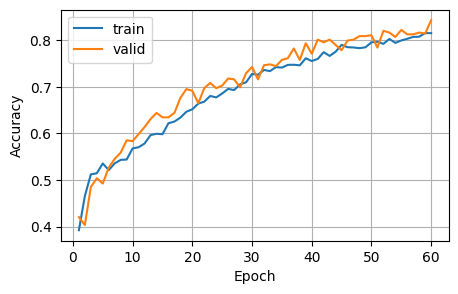

In [ ]:
plt.figure(figsize=(5, 3))
plt.rcParams["font.size"]=10
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

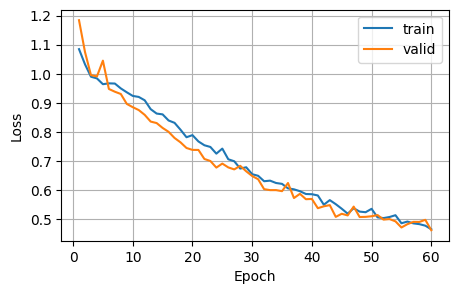

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Make Submission File

In [ ]:
###################################
##  DO NOT CHANGE THE CODE HERE  ##
###################################

p_label_all = np.array([])

with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        p_batch = model(x_batch)
        p_batch_label = torch.argmax(p_batch, dim=1)
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())

p_label_all = p_label_all.astype("uint8")
print(p_label_all)

df_submit = pd.DataFrame()
df_submit["ID"] = np.arange(len(test_dataset))
df_submit["Target"] = p_label_all

df_submit.to_csv("your_submission.csv", index = False)

df_submit

[1 2 2 ... 2 2 0]


,ID,Target
0,0,1
1,1,2
2,2,2
3,3,0
4,4,0
...,...,...
4174,4174,2
4175,4175,1
4176,4176,2
4177,4177,2


### Submition from Kaggle
You can now download `your_submission.csv` file from the 'Files' tab, and proceed to submit it on our competition page on Kaggle

## Conclusion

That's it for this week. Try your best for the image classification competition!